In [2]:
import pandas as pd
import numpy as np

In [3]:
file_path = '../data/owid-covid-data.csv'
df = pd.read_csv(file_path)
df = df[['date', 'new_deaths','icu_patients', 'new_tests', 'hosp_patients', 'reproduction_rate']]
df = df.groupby('date').sum().reset_index()
df = df.dropna()
df['date'] = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')
#df.set_index(date_time, inplace=True, drop=False)

train = df.iloc[:-60]
valid = df.iloc[-60:]

In [4]:
import orbit
from orbit.models import ETS

ets = ETS(date_col='date', 
          response_col='new_deaths', 
          seasonality=7,
          prediction_percentiles=[5, 95],
          seed=1)
train.columns

Index(['new_deaths', 'icu_patients', 'new_tests', 'hosp_patients',
       'reproduction_rate', 'date'],
      dtype='object')

In [5]:
train_ets = train[['date','new_deaths']].copy()

ets.fit(df=train_ets)

2023-10-15 20:56:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
Widget Javascript not detected.  It may not be installed or enabled properly.


In [6]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
forecast_df = valid[['date']]
p = ets.predict(df=forecast_df)
p = p.merge(valid, on='date', how='left')

print(wmape(p['new_deaths'], p['prediction']))

2.800629743720699


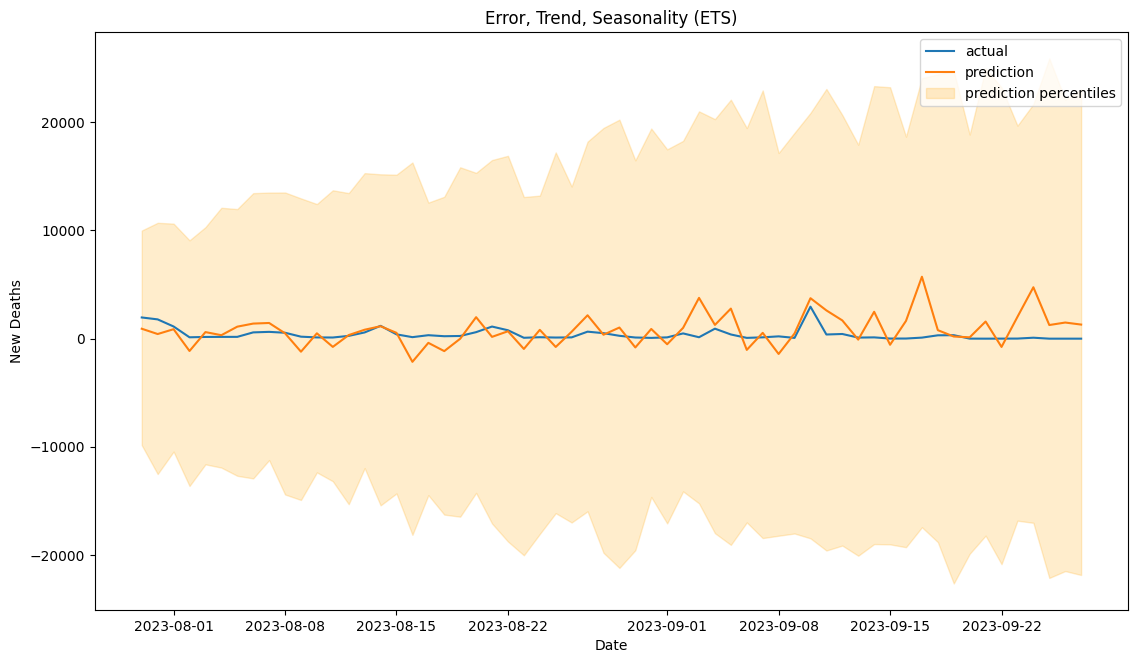

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p['date'], p['new_deaths'], label='actual')
ax.plot(p['date'], p['prediction'], label='prediction')
ax.fill_between(p['date'], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Error, Trend, Seasonality (ETS)')
ax.set_ylabel('New Deaths')
ax.set_xlabel('Date')
ax.legend()
plt.show()

In [9]:
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester

scores = dict()
for global_trend_option in ['linear', 'loglinear', 'flat', 'logistic']:
    dlt = DLT(date_col='date', 
            response_col='new_deaths', 
            seasonality=7,
            prediction_percentiles=[5, 95],
            regressor_col=['icu_patients'],
            regressor_sign=['='],
            regression_penalty='auto_ridge',
            damped_factor=0.8,
            seed=2, # if you get errors due to less than zero values, try a different seed
            global_trend_option=global_trend_option,
            verbose=False)

    bt = BackTester(df=train, 
                    model=dlt, 
                    forecast_len=90,
                    n_splits=5,
                    window_type='rolling')

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    scores[global_trend_option] = wmape(predicted_df['actual'], predicted_df['prediction'])

In [10]:
best_global_trend_option = min(scores, key=scores.get)    

dlt = DLT(date_col='date', 
        response_col='new_deaths', 
        seasonality=7,
        prediction_percentiles=[5, 95],
        regressor_col=['icu_patients'],
        regressor_sign=['='],
        regression_penalty='auto_ridge',
        damped_factor=0.8,
        seed=2, # if you get errors due to less than zero values, try a different seed
        global_trend_option=best_global_trend_option,
        verbose=False)

dlt.fit(df=train)

In [11]:
p = dlt.predict(df=valid[['date', 'icu_patients']])
p = p.merge(valid, on='date', how='left')

print(wmape(p['new_deaths'], p['prediction']))

1.9782085036259203


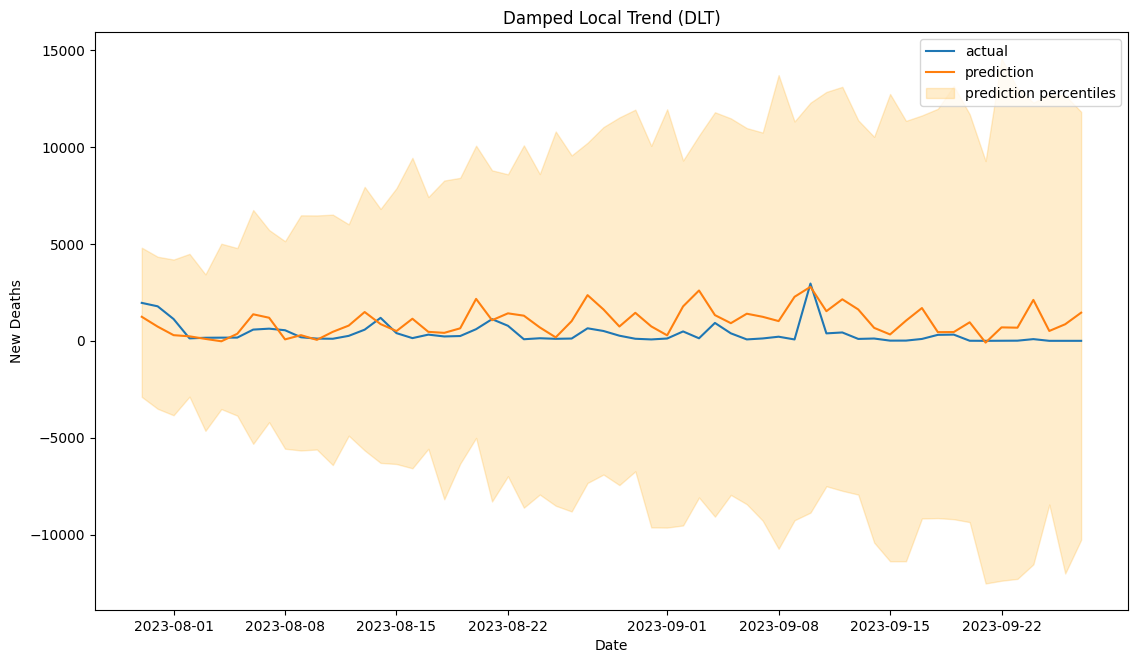

In [12]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p['date'], p['new_deaths'], label='actual')
ax.plot(p['date'], p['prediction'], label='prediction')
ax.fill_between(p['date'], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel('Date')
ax.legend()
plt.show()

In [17]:
from orbit.models import KTR

ktr = KTR(date_col='date', 
        response_col='new_deaths', 
        seasonality=[7, 28],
        prediction_percentiles=[5, 95],
        regressor_col=['icu_patients'],
        seed=2,
        verbose=False)

ktr.fit(df=train)

p = ktr.predict(df=valid[['date', 'icu_patients']])
p = p.merge(valid, on='date', how='left')

print(wmape(p['new_deaths'], p['prediction']))

2023-10-15 21:16:05 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-15 21:16:05 - orbit - INFO - First time in running stan model:ktrlite. Expect 3 - 5 minutes for compilation.
/home/sambros/.local/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/sambros/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally

5.036288005308185


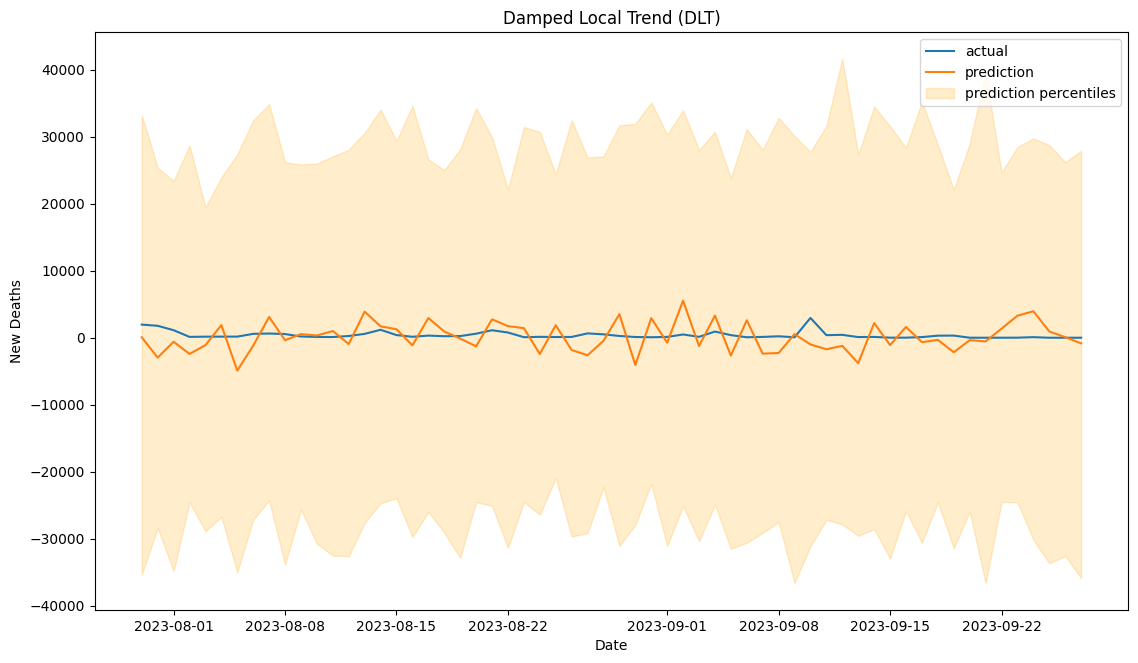

In [18]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p['date'], p['new_deaths'], label='actual')
ax.plot(p['date'], p['prediction'], label='prediction')
ax.fill_between(p['date'], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel('Date')
ax.legend()
plt.show()